# Inspeção de Componentes de Vagões Ferroviários Baseado em Visão Computacional e Aprendizagem Profunda

Leonardo Borges de Castro (castro.b.leonardo@gmail.com)

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Código desenvolvido por:

@misc{wu2019detectron2,
  author =       {Yuxin Wu and Alexander Kirillov and Francisco Massa and
                  Wan-Yen Lo and Ross Girshick},
  title =        {Detectron2},
  howpublished = {\url{https://github.com/facebookresearch/detectron2}},
  year =         {2019}
}

Com adapatações para registro no formato PASCAL VOC de:
https://medium.com/deepvisionguru/train-license-plates-detection-model-using-detectron2-dd166154f604


# Install detectron2

In [1]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 25kB/s 
     |████████████████████████████████| 4.1MB 48.6MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101
     |████████████████████████████████| 276kB 6.6MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=1162f4b50621d30e5c2391b0b2f19e3e21cdc3d14784fd19ff44b03490906bd4
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-b

In [2]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 5.9MB 596kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200622-cp36-none-any.whl size=41182 sha256=dd216298804ce941af5e8a52186386fd09ec00555f329978abdea47b50c94d55
  Stored in directory: /root/.cache/pip/wheels/ed/12/91/133f4d4c09919f23f6d8fd7953884c79844bfb682e59259f31
Successfully built fvcore


In [3]:
!pip show detectron2

Name: detectron2
Version: 0.1.3+cu100
Summary: Detectron2 is FAIR's next-generation research platform for object detection and segmentation.
Home-page: https://github.com/facebookresearch/detectron2
Author: FAIR
Author-email: None
License: UNKNOWN
Location: /usr/local/lib/python3.6/dist-packages
Requires: matplotlib, tabulate, future, Pillow, tensorboard, fvcore, tqdm, pydot, cloudpickle, termcolor, yacs, mock
Required-by: 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the balloon segmentation dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon)
which only has one class: balloon.
We'll train a balloon segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have the "balloon" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

In [ ]:
# Montando o Google Drive com a base de imagens e códigos...
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Endereço do código para dividir o dataset em treino e teste...
%cd '/content/drive/My Drive/Colab Notebooks/detectron2-licenseplates-master'
!python split.py

/content/drive/My Drive/Colab Notebooks/detectron2-licenseplates-master

Arquivos gerados em  /content/drive/My Drive/Colab Notebooks/detectron2-licenseplates-master/datasets/licenseplates/

Total de Imagens 367
Total treinamento+validação 294
Total para teste 73
Total para treinamento 236
Total para validação 58


In [6]:
# Registrar o dataset padrão VOC no Detectron2 (codigo direto)...

from fvcore.common.file_io import PathManager
import os
import numpy as np
import xml.etree.ElementTree as ET

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog


__all__ = ["register_licenseplates_voc"]


CLASS_NAMES = [
    "MOLAS","TAG","FREIO","ESCADA","ROLAMENTOS", "ENGATE_FIXO","ENGATE_ROTATIVO","VALVULA_SERRA","LOCOMOTIVA",
]


def load_voc_instances(dirname: str, split: str):
    """
    Load licenseplates VOC detection annotations to Detectron2 format.

    Args:
        dirname: Contain "annotations", "images"
        split (str): one of "train", "test"
    """
    with PathManager.open(os.path.join(dirname, split + ".txt")) as f:
        fileids = np.loadtxt(f, dtype=np.str)

    dicts = []
    for fileid in fileids:
        anno_file = os.path.join(dirname, "annotations", fileid + ".xml")
        jpeg_file = os.path.join(dirname, "images", fileid + ".jpg")

        tree = ET.parse(anno_file)

        r = {
            "file_name": jpeg_file,
            "image_id": fileid,
            "height": int(tree.findall("./size/height")[0].text),
            "width": int(tree.findall("./size/width")[0].text),
        }
        instances = []

        for obj in tree.findall("object"):
            cls = obj.find("name").text
            bbox = obj.find("bndbox")
            bbox = [float(bbox.find(x).text) for x in ["xmin", "ymin", "xmax", "ymax"]]
            instances.append(
                {"category_id": CLASS_NAMES.index(cls), "bbox": bbox, "bbox_mode": BoxMode.XYXY_ABS}
            )
        r["annotations"] = instances
        dicts.append(r)
        print(fileid)
    return dicts


def register_licenseplates_voc(name, dirname, split):
    DatasetCatalog.register(name,
                            lambda: load_voc_instances(dirname, split))
    MetadataCatalog.get(name).set(thing_classes=CLASS_NAMES,
                                  dirname=dirname,
                                  split=split)

import random
import cv2
from google.colab.patches import cv2_imshow
from detectron2.utils.visualizer import Visualizer
import argparse

dataset_name = f"licenseplates_train"
register_licenseplates_voc(dataset_name, "/content/drive/My Drive/Colab Notebooks/detectron2-licenseplates-master/datasets/licenseplates", "train")
dataset_dicts = DatasetCatalog.get(dataset_name)
print("Dataset de Treinamento Registrado")

dataset_name_test = f"licenseplates_test"
register_licenseplates_voc(dataset_name_test, "/content/drive/My Drive/Colab Notebooks/detectron2-licenseplates-master/datasets/licenseplates", "test")
dataset_dicts_test = DatasetCatalog.get(dataset_name_test)
print("Dataset de Testes Registrado")

vagoes0
vagoes1
vagoes10
vagoes100
vagoes101
vagoes102
vagoes103
vagoes104
vagoes105
vagoes106
vagoes107
vagoes109
vagoes11
vagoes111
vagoes112
vagoes113
vagoes114
vagoes115
vagoes116
vagoes117
vagoes118
vagoes119
vagoes12
vagoes120
vagoes121
vagoes122
vagoes123
vagoes124
vagoes126
vagoes127
vagoes128
vagoes129
vagoes131
vagoes132
vagoes133
vagoes136
vagoes137
vagoes138
vagoes139
vagoes14
vagoes140
vagoes141
vagoes142
vagoes143
vagoes144
vagoes145
vagoes146
vagoes147
vagoes148
vagoes15
vagoes150
vagoes152
vagoes153
vagoes154
vagoes155
vagoes157
vagoes158
vagoes159
vagoes16
vagoes160
vagoes161
vagoes162
vagoes163
vagoes164
vagoes165
vagoes166
vagoes167
vagoes168
vagoes169
vagoes170
vagoes171
vagoes172
vagoes173
vagoes174
vagoes175
vagoes176
vagoes177
vagoes179
vagoes18
vagoes181
vagoes182
vagoes183
vagoes184
vagoes185
vagoes186
vagoes187
vagoes189
vagoes19
vagoes190
vagoes191
vagoes192
vagoes193
vagoes196
vagoes197
vagoes198
vagoes199
vagoes2
vagoes20
vagoes200
vagoes201
vagoes202
vagoe

In [7]:
# registro do dataset de treino...
dataset_dicts

[{'annotations': [{'bbox': [711.0, 544.0, 813.0, 588.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0},
   {'bbox': [1507.0, 531.0, 1578.0, 568.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0},
   {'bbox': [664.0, 223.0, 1088.0, 290.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 1},
   {'bbox': [1408.0, 466.0, 1478.0, 533.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 2},
   {'bbox': [102.0, 177.0, 211.0, 549.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 3},
   {'bbox': [1672.0, 272.0, 1723.0, 541.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 3},
   {'bbox': [576.0, 520.0, 638.0, 584.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 4},
   {'bbox': [881.0, 520.0, 940.0, 576.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 4},
   {'bbox': [291.0, 446.0, 521.0, 580.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 5}],
  'file_name': '/content/drive/M

In [8]:
# registro do dataset de teste...
dataset_dicts_test

[{'annotations': [{'bbox': [594.0, 247.0, 1481.0, 352.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 1},
   {'bbox': [453.0, 834.0, 602.0, 977.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 4},
   {'bbox': [1057.0, 822.0, 1208.0, 957.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 4},
   {'bbox': [711.0, 872.0, 951.0, 985.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0},
   {'bbox': [8.0, 715.0, 380.0, 979.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 5}],
  'file_name': '/content/drive/My Drive/Colab Notebooks/detectron2-licenseplates-master/datasets/licenseplates/images/vagoes108.jpg',
  'height': 1080,
  'image_id': 'vagoes108',
  'width': 1920},
 {'annotations': [{'bbox': [64.0, 703.0, 557.0, 985.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 6},
   {'bbox': [667.0, 823.0, 815.0, 963.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 4},
   {'bbox': [1265.0, 819.0, 1429.0, 9

In [9]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [10]:
!/opt/bin/nvidia-smi
!nvcc --version

Mon Jun 22 14:49:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    58W / 149W |    324MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



In [11]:
# Visualizar algumas imagens registradas (base de treinamento)...

import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

amostras = 3
for d in random.sample(dataset_dicts, amostras):
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1], metadata = MetadataCatalog.get(dataset_name), scale=0.5)
  vis = visualizer.draw_dataset_dict(d)
  cv2_imshow(vis.get_image()[:, :, ::-1])
  
  #Exit? Press ESC
  if cv2.waitKey(0) & 0xFF == 27:
    break

cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.

In [12]:
# Visualizar algumas imagens registradas (base de testes)...

import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

amostras = 3
for d in random.sample(dataset_dicts_test, amostras):
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1], metadata = MetadataCatalog.get(dataset_name_test), scale=0.5)
  vis = visualizer.draw_dataset_dict(d)
  cv2_imshow(vis.get_image()[:, :, ::-1])
  
  #Exit? Press ESC
  if cv2.waitKey(0) & 0xFF == 27:
    break

cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.

## Train!

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.


In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("PascalVOC-Detection/faster_rcnn_R_50_C4.yaml"))
cfg.DATASETS.TRAIN = ("licenseplates_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("PascalVOC-Detection/faster_rcnn_R_50_C4.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 30000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 9  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

#!cp "./output/model_final.pth" "/content/drive/My Drive/Colab Notebooks/detectron2-licenseplates-master/licenseplates/output"

[05/07 22:48:41 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

In [ ]:
!cp "./output/model_final.pth" "/content/drive/My Drive/Colab Notebooks/detectron2-licenseplates-master/licenseplates/output"

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [ ]:
# carregar um modelo treinado neste momento...
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "./model_final.pth")

# carregar um modelo já treinado...
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/content/drive/My Drive/Colab Notebooks/detectron2-licenseplates-master/licenseplates/output/model_final.pth")


cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75   # set the testing threshold for this model (REDUZIR FALSOS POSITIVOS)
cfg.DATASETS.TEST = ("licenseplates_test", )
predictor = DefaultPredictor(cfg)


Then, we randomly select several samples to visualize the prediction results.

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts_test, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get(dataset_name_test), 
                   scale=0.8, 
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70%. Not bad!

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("licenseplates_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "licenseplates_test")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

vagoes108
vagoes110
vagoes125
vagoes13
vagoes130
vagoes134
vagoes135
vagoes149
vagoes151
vagoes156
vagoes17
vagoes178
vagoes180
vagoes188
vagoes194
vagoes195
vagoes205
vagoes21
vagoes210
vagoes216
vagoes217
vagoes223
vagoes224
vagoes232
vagoes233
vagoes238
vagoes244
vagoes248
vagoes252
vagoes253
vagoes262
vagoes263
vagoes264
vagoes268
vagoes273
vagoes280
vagoes281
vagoes284
vagoes291
vagoes299
vagoes30
vagoes301
vagoes304
vagoes309
vagoes318
vagoes32
vagoes321
vagoes324
vagoes329
vagoes334
vagoes335
vagoes34
vagoes348
vagoes349
vagoes358
vagoes361
vagoes365
vagoes37
vagoes38
vagoes39
vagoes4
vagoes41
vagoes46
vagoes51
vagoes64
vagoes70
vagoes73
vagoes74
vagoes77
vagoes86
vagoes88
vagoes89
vagoes97
[05/08 01:44:00 d2.data.common]: Serializing 73 elements to byte tensors and concatenating them all ...
[05/08 01:44:00 d2.data.common]: Serialized dataset takes 0.05 MiB
[05/08 01:44:00 d2.evaluation.evaluator]: Start inference on 73 images
[05/08 01:44:03 d2.evaluation.evaluator]: Inference

OrderedDict([('bbox',
              {'AP': 59.372526972781856,
               'AP-ENGATE_FIXO': 61.71768857682783,
               'AP-ENGATE_ROTATIVO': 54.09485195449086,
               'AP-ESCADA': 61.604745408961314,
               'AP-FREIO': 49.37293729372937,
               'AP-LOCOMOTIVA': nan,
               'AP-MOLAS': 57.21723099995758,
               'AP-ROLAMENTOS': 61.29649286649821,
               'AP-TAG': 63.57065812073361,
               'AP-VALVULA_SERRA': 66.10561056105611,
               'AP50': 90.97501868880286,
               'AP75': 71.77065034904018,
               'APl': 59.474478092751816,
               'APm': 57.44005720858829,
               'APs': nan})])

## CARREGAR UM MODELO PREVIAMENTE TREINADO

In [13]:
from detectron2.modeling import build_model

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("PascalVOC-Detection/faster_rcnn_R_50_C4.yaml"))
cfg.DATASETS.TEST = ("licenseplates_test")
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 9  # only has one class (ballon)
cfg.MODEL.WEIGHTS = "/content/drive/My Drive/Colab Notebooks/detectron2-licenseplates-master/output/model_final.pth"
cfg.MODEL.SCORE_THRESH_TEST = 0.75
cfg.MODEL.DEVICE='cuda'

predictor = DefaultPredictor(cfg)

In [14]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts_test, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get(dataset_name_test), 
                   scale=0.8, 
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

In [15]:
outputs

{'instances': Instances(num_instances=10, image_height=1080, image_width=1920, fields=[pred_boxes: Boxes(tensor([[ 863.0476,  658.9181,  977.7554,  774.6848],
         [1054.0890,  703.2695, 1205.4956,  782.8058],
         [1717.2758,  684.5039, 1797.7869,  758.5270],
         [1361.1641,  254.0255, 1477.2760,  699.2740],
         [1246.7432,  673.9175, 1355.7495,  772.1970],
         [1429.7954,  577.0195, 1620.2926,  761.2624],
         [1842.1984,  720.7088, 1920.0000,  780.7839],
         [1842.3610,  715.7213, 1920.0000,  785.5403],
         [1339.2975,  241.9806, 1488.1644,  684.1044],
         [1440.2892,  585.3635, 1601.1671,  763.7471]], device='cuda:0')), scores: tensor([0.9635, 0.9596, 0.9583, 0.9577, 0.9412, 0.8630, 0.3871, 0.0976, 0.0726,
         0.0543], device='cuda:0'), pred_classes: tensor([4, 0, 4, 3, 4, 6, 0, 4, 0, 0], device='cuda:0')])}

In [16]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("licenseplates_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "licenseplates_test")
resultados = inference_on_dataset(predictor.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [06/22 14:51:42 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'licenseplates_test'. Trying to convert it to COCO format ...
[06/22 14:51:42 d2.data.datasets.coco]: Converting annotations of dataset 'licenseplates_test' to COCO format ...)
vagoes108
vagoes110
vagoes125
vagoes13
vagoes130
vagoes134
vagoes135
vagoes149
vagoes151
vagoes156
vagoes17
vagoes178
vagoes180
vagoes188
vagoes194
vagoes195
vagoes205
vagoes21
vagoes210
vagoes216
vagoes217
vagoes223
vagoes224
vagoes232
vagoes233
vagoes238
vagoes244
vagoes248
vagoes252
vagoes253
vagoes262
vagoes263
vagoes264
vagoes268
vagoes273
vagoes280
vagoes281
vagoes284
vagoes291
vagoes299
vagoes30
vagoes301
vagoes304
vagoes309
vagoes318
vagoes32
vagoes321
vagoes324
vagoes329
vagoes334
vagoes335
vagoes34
vagoes348
vagoes349
vagoes358
vagoes361
vagoes365
vagoes37
vagoes38
vagoes39
vagoes4
vagoes41
vagoes46
vagoes51
vagoes64
vagoes70
vagoes73
vagoes74
vagoes77
vagoes86
vagoes88
vagoes89
vagoes97
[06/22 14:51:

In [17]:
from detectron2.data.build import print_instances_class_histogram
print_instances_class_histogram(dataset_dicts_test,CLASS_NAMES)

In [18]:
import itertools
import logging
from tabulate import tabulate
from detectron2.utils.logger import log_first_n
from termcolor import colored

dataset_dictss = dataset_dicts
class_names = CLASS_NAMES

num_classes = len(class_names)
hist_bins = np.arange(num_classes + 1)
histogram = np.zeros((num_classes,), dtype=np.int)
for entry in dataset_dictss:
  annos = entry["annotations"]
  classes = [x["category_id"] for x in annos if not x.get("iscrowd", 0)]
  histogram += np.histogram(classes, bins=hist_bins)[0]
  
N_COLS = min(6, len(class_names) * 2)

def short_name(x):
  # make long class names shorter. useful for lvis
  if len(x) > 13:
    return x[:11] + ".."
  return x
  
data = list(itertools.chain(*[[short_name(class_names[i]), int(v)] for i, v in enumerate(histogram)]))

total_num_instances = sum(data[1::2])
data.extend([None] * (N_COLS - (len(data) % N_COLS)))

if num_classes > 1:
  data.extend(["total", total_num_instances])
  data = itertools.zip_longest(*[data[i::N_COLS] for i in range(N_COLS)])
  
  table = tabulate(
      data,
      headers=["category", "#instances"] * (N_COLS // 2),
      tablefmt="pipe",
      numalign="left",
      stralign="center",)
  
  #log_first_n(logging.INFO, "Distribution of instances among all {} categories:\n".format(num_classes) + colored(table, "cyan"), key="message",)


In [19]:
print(table)

|   category    | #instances   |   category    | #instances   |  category   | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-----------:|:-------------|
|     MOLAS     | 370          |      TAG      | 201          |    FREIO    | 27           |
|    ESCADA     | 115          |  ROLAMENTOS   | 735          | ENGATE_FIXO | 90           |
| ENGATE_ROTA.. | 67           | VALVULA_SERRA | 20           | LOCOMOTIVA  | 0            |
|               |              |               |              |             |              |
|     total     | 1625         |               |              |             |              |


In [20]:
!dir ./output/

coco_instances_results.json  licenseplates_test_coco_format.json
instances_predictions.pth    licenseplates_test_coco_format.json.lock


In [21]:
# Converter json para csv (resultados das predições)

import pandas as pd
df1 = pd.read_json (r'/content/output/coco_instances_results.json')
df1.to_csv (r'/content/drive/My Drive/Colab Notebooks/detectron2-licenseplates-master/output/coco_instances_results.csv', index = None)

In [26]:
df2 = pd.DataFrame(dataset_dicts_test)

In [27]:
df2.to_json(r'/content/drive/My Drive/Colab Notebooks/detectron2-licenseplates-master/output/dataset_dicts_test.json')

In [28]:
df2.to_csv (r'/content/drive/My Drive/Colab Notebooks/detectron2-licenseplates-master/output/dataset_dicts_test.csv', index = None)

In [22]:
dataset_dicts_test

[{'annotations': [{'bbox': [594.0, 247.0, 1481.0, 352.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 1},
   {'bbox': [453.0, 834.0, 602.0, 977.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 4},
   {'bbox': [1057.0, 822.0, 1208.0, 957.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 4},
   {'bbox': [711.0, 872.0, 951.0, 985.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0},
   {'bbox': [8.0, 715.0, 380.0, 979.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 5}],
  'file_name': '/content/drive/My Drive/Colab Notebooks/detectron2-licenseplates-master/datasets/licenseplates/images/vagoes108.jpg',
  'height': 1080,
  'image_id': 'vagoes108',
  'width': 1920},
 {'annotations': [{'bbox': [64.0, 703.0, 557.0, 985.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 6},
   {'bbox': [667.0, 823.0, 815.0, 963.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 4},
   {'bbox': [1265.0, 819.0, 1429.0, 9

## PROCESSAMENTO DE VIDEO

In [ ]:
# Download Video...

from google.colab import files

video = files.download('/content/drive/My Drive/Colab Notebooks/detectron2-licenseplates-master/Video/vagoes2.mp4')

In [ ]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

In [ ]:
show_local_mp4_video('/content/drive/My Drive/Colab Notebooks/detectron2-licenseplates-master/Video/vagoes2.mp4')

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/drive/My Drive/Colab Notebooks/detectron2-licenseplates-master/Video/vagoes2.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

In [ ]:
!ffmpeg -i "/content/drive/My Drive/Colab Notebooks/detectron2-licenseplates-master/Video/vagoes2.mp4" -t 00:00:06 -c:v copy video-clip.mp4

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [ ]:
!dir

drive  sample_data  video-clip.mp4


In [ ]:
# Run frame-by-frame inference demo on this video (takes 3-4 minutes)
# Using a model trained on COCO dataset

!python detectron2/demo/demo.py --config-file detectron2/configs/PascalVOC-Detection/faster_rcnn_R_50_C4.yaml --video-input video-clip.mp4 --confidence-threshold 0.6 --output video-output.mkv \
  --opts MODEL.WEIGHTS detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl

In [ ]:
from IPython.display import YouTubeVideo, display
display("/content/video-clip.mp4")

'/content/video-clip.mp4'

In [ ]:
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

# Other types of builtin models

In [ ]:
# Inference with a keypoint detection model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

model_final_cafdb1.pkl: 261MB [00:20, 12.5MB/s]                           


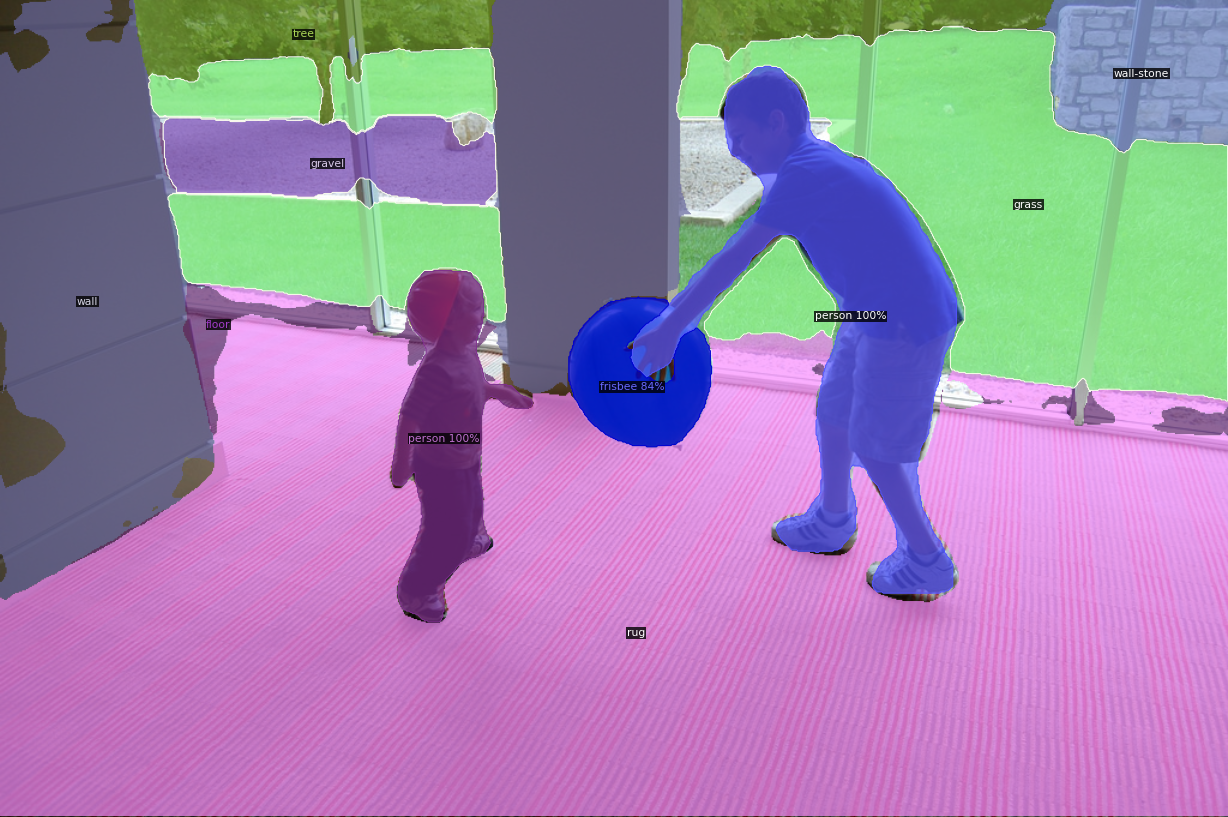

In [ ]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(v.get_image()[:, :, ::-1])

# Run panoptic segmentation on a video

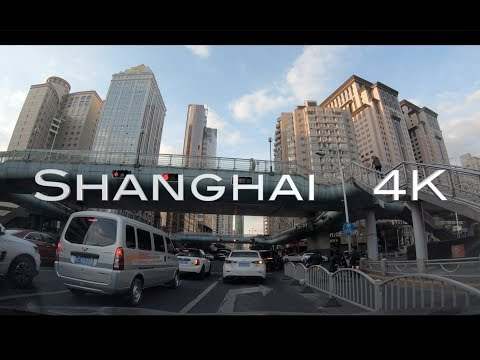

In [ ]:
# This is the video we're going to process
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("ll8TgCZ0plk", width=500)
display(video)

In [ ]:
# Install dependencies, download the video, and crop 5 seconds for processing
!pip install youtube-dl
!pip uninstall -y opencv-python opencv-contrib-python
!apt install python3-opencv  # the one pre-installed have some issues
!youtube-dl https://www.youtube.com/watch?v=ll8TgCZ0plk -f 22 -o video.mp4
!ffmpeg -i video.mp4 -t 00:00:06 -c:v copy video-clip.mp4

     |████████████████████████████████| 1.8MB 8.3MB/s 
Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
Uninstalling opencv-contrib-python-4.1.2.30:
  Successfully uninstalled opencv-contrib-python-4.1.2.30
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  python3-opencv
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 534 kB of archives.
After this operation, 2,941 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 python3-opencv amd64 3.2.0+dfsg-4ubuntu0.1 [534 kB]
Fetched 534 kB in 0s (3,684 kB/s)
Selecting previously unselected package python3-opencv.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../python3-opencv_3.2.0+dfsg-4ubuntu0.1_amd64.deb ...
Unpacking python3-opencv (3.2.0+dfsg-4ubuntu0.1) ...
Setting up python3

In [ ]:
# Run frame-by-frame inference demo on this video (takes 3-4 minutes)
# Using a model trained on COCO dataset
!git clone https://github.com/facebookresearch/detectron2
!python detectron2/demo/demo.py --config-file detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml --video-input video-clip.mp4 --confidence-threshold 0.6 --output video-output.mkv \
  --opts MODEL.WEIGHTS detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl

Cloning into 'detectron2'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 4072 (delta 26), reused 41 (delta 16), pack-reused 3974
Receiving objects: 100% (4072/4072), 2.36 MiB | 4.52 MiB/s, done.
Resolving deltas: 100% (2807/2807), done.
Failed to load OpenCL runtime
[04/21 01:58:15 detectron2]: Arguments: Namespace(confidence_threshold=0.6, config_file='detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml', input=None, opts=['MODEL.WEIGHTS', 'detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl'], output='video-output.mkv', video_input='video-clip.mp4', webcam=False)
[04/21 01:58:19 fvcore.common.checkpoint]: Loading checkpoint from detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl
[04/21 01:58:19 fvcore.common.file_io]: URL https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSe

In [ ]:
# Download the results
from google.colab import files
files.download('/content/drive/My Drive/Colab Notebooks/detectron2-licenseplates-master/Video/vagoes2.mp4')